- Step 1. 데이터 다운로드
- Step 2. 데이터 정제
- Step 3. 데이터 토큰화
- Step 4. 모델 설계
- Step 5. 훈련하기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import numpy as np
import pandas as pd

from konlpy.tag import Kkma
from konlpy.tag import Mecab


from sklearn.model_selection import train_test_split

import time
import re
import os
import io

In [2]:
path_kor = '/aiffel/aiffel/korean-english-park.train.ko'
path_eng = '/aiffel/aiffel/korean-english-park.train.en'

with open(path_kor, "r") as f:
    raw_kor = f.read().splitlines()

with open(path_eng, "r") as f:
    raw_eng = f.read().splitlines()
    
    
print("Data Size:", len(raw_kor))
print("Korean_Example:")
for sen in raw_kor[0:40][::2]: print(">>", sen)
print()
print("Data Size:", len(raw_eng))
print("English_Example:")
for sen in raw_eng[0:40][::20]: print(">>", sen)

Data Size: 94123
Korean_Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.
>> 아시아에서의 왕성한 수요 덕분에 일본의 수출이 9월에 연속 6개월간 증가하여, 무역 흑자가 1조550억엔(84억7,000만달러)으로 늘어났다고 재무성이 발표했다.
>> 특수 부대가 극장 건물로 공격해 들어가면서, 러시아인이 아닌 75명의 외국인과 25명의 어린이 전부를 포함해 750명 이상의 인질들이 구출되었다.
>> 많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다.
>> 실바의 노동자당이 자신들의 후보가 선거의 승리자라고 선언한 후 몇 시간이 지나, 집권당 후보인 조제 세하는 패배를 시인했다.
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> 100여명의 사망자가 예상되는 베트남 빌딩 화재
>> 최초 보도에 의하면 그 화재는 건물 2층의 Blue Disco에서 누전에 의해 발화되었을 것이라고 했다

## Step 2. 데이터 정제

In [3]:
def preprocess_enc_sentence(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()
    return sentence


def preprocess_dec_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = '<start> ' + sentence
    sentence += ' <end>'
    
    return sentence

In [4]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for kor in raw_kor[:num_examples]:
    enc_corpus.append(preprocess_enc_sentence(kor))
    
for eng in raw_eng[:num_examples]:
    dec_corpus.append(preprocess_dec_sentence(eng))

print("한국어:", enc_corpus[0])
print() 
print("영어:", dec_corpus[0]) 

한국어: 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?

영어: <start> much of personal computing is about can you top this ? <end>


## Step 3. 데이터 토큰화

In [5]:
df = pd.DataFrame()
df['kor'] = pd.DataFrame(enc_corpus)
df['eng'] = pd.DataFrame(dec_corpus)
df['target'] = 0 # 나중에 한글 형태소 단위로 쪼개고 40이 넘으면 1로 바꾸고 삭제.

In [6]:
df.drop_duplicates(inplace=True)
df

,kor,eng,target
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<start> much of personal computing is about ca...,0
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<start> so a mention a few weeks ago about a r...,0
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<start> like all optical mice , but it also do...",0
3,". 달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분이...",<start> uses gyroscopic sensors to control the...,0
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,<start> intelligence officials have revealed a...,0
...,...,...,...
29995,일각에서는 대법원이 무샤라프의 당선은 무효라는 판결을 내릴 경우 그가 계엄령을 선포...,<start> a majority a vast majority have voted ...,0
29996,미국 위스콘신 주 크랜든에서 일 오전 현지시간 비번이던 보안관이 총기를 난사해 명이...,<start> cnn an off duty sheriff s deputy shot ...,0
29997,용의자는 타일러 피터슨은 크랜든 보안관겸 비 상근직 경찰로 근무해 온 것으로 알려졌다 .,"<start> the deputy , tyler peterson , also wor...",0
29998,케이스 반 클레브 포레스트카운티 보안관은 피터슨이 대였다고 전했다 .,<start> forest county sheriff keith van cleve ...,0


In [7]:
mecab = Mecab()
df['kor'].apply(lambda x: mecab.morphs(x))

0        [개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...
1        [모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...
2           [그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]
3        [., 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔...
4        [정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...
                               ...                        
29995    [일각, 에서, 는, 대, 법원, 이, 무샤라프, 의, 당선, 은, 무효, 라는, ...
29996    [미국, 위스콘신, 주, 크, 랜든, 에서, 일, 오전, 현지, 시간, 비번, 이,...
29997    [용의자, 는, 타일러, 피터슨, 은, 크랜, 든, 보안관, 겸, 비, 상근, 직,...
29998    [케이스, 반, 클레브, 포레스트, 카운티, 보안관, 은, 피터슨, 이, 대, 였,...
29999    [WTMJ, 밀워키, 지역, 라디오, 방송국, 은, 사망자, 중, 명, 이, 크, ...
Name: kor, Length: 29929, dtype: object

In [8]:
for idx, i in enumerate(df.kor):
    if len(i) > 40:
        df.target[idx] = 1

/tmp/ipykernel_242/2476254194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.target[idx] = 1


In [9]:
count = 0
for i in df.target:
    if i == 1:
        count +=1

print('한국어 문장 토큰 중 토큰이 40개 이하 =',len(df.kor) - count)        

한국어 문장 토큰 중 토큰이 40개 이하 = 5388


In [10]:
df_target_1 = df[df.target ==1].index
df_new = df.drop(df_target_1)

In [11]:
df_new

,kor,eng,target
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<start> much of personal computing is about ca...,0
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<start> like all optical mice , but it also do...",0
8,결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다 .,<start> something that will boost their capabi...,0
16,많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다 .,<start> many captives were taken to hospital s...,0
22,여명의 사망자가 예상되는 베트남 빌딩 화재,<start> at least people have been confirmed de...,0
...,...,...,...
29995,일각에서는 대법원이 무샤라프의 당선은 무효라는 판결을 내릴 경우 그가 계엄령을 선포...,<start> a majority a vast majority have voted ...,0
29996,미국 위스콘신 주 크랜든에서 일 오전 현지시간 비번이던 보안관이 총기를 난사해 명이...,<start> cnn an off duty sheriff s deputy shot ...,0
29997,용의자는 타일러 피터슨은 크랜든 보안관겸 비 상근직 경찰로 근무해 온 것으로 알려졌다 .,"<start> the deputy , tyler peterson , also wor...",0
29998,케이스 반 클레브 포레스트카운티 보안관은 피터슨이 대였다고 전했다 .,<start> forest county sheriff keith van cleve ...,0


In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
enc_tensor, enc_tokenizer = tokenize(df_new['kor'].tolist())
dec_tensor, dec_tokenizer = tokenize(df_new['eng'].tolist())

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print('enc_tensor', enc_tensor.shape)
print('enc_tensor', enc_tensor.shape)

enc_tensor (5388, 46)
enc_tensor (5388, 46)


## Step 4. 모델 설계


In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [17]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 12685)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## Step 5. 훈련하기

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [19]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [20]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 60

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 60: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s, Loss 2.0146]


In [21]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s, Test Loss 2.0482]


Input: 오바마 는 대통령 이 다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_242/1207125078.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_242/1207125078.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


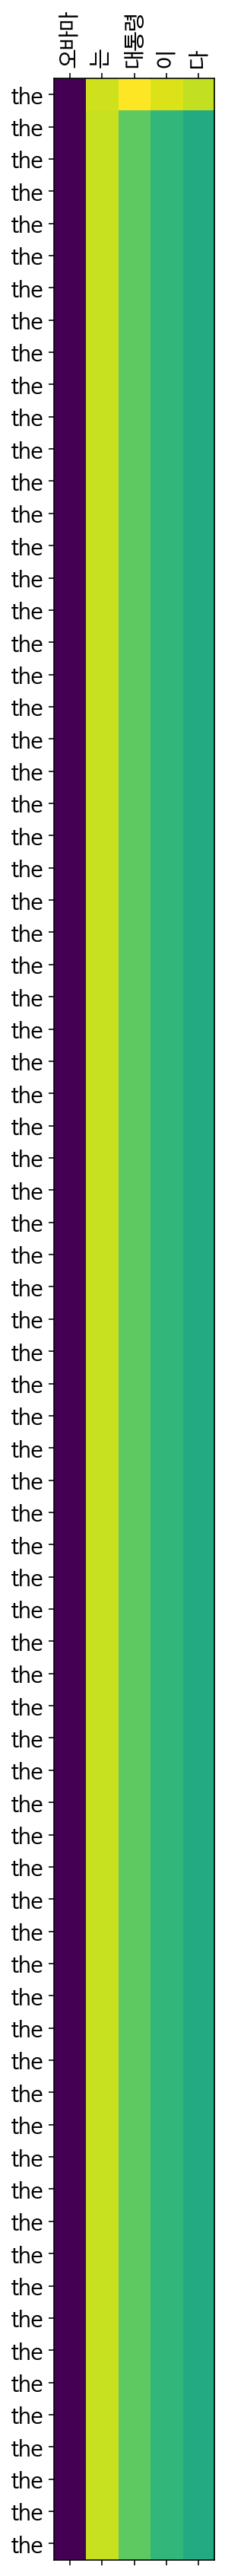

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_enc_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오바마 는 대통령 이 다", encoder, decoder)